In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from datetime import datetime
import warnings
warnings.filterwarnings(action = 'ignore')
pd.pandas.set_option('display.max_columns', None)

In [2]:
from sklearn.model_selection import train_test_split
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score

In [3]:
df = pd.read_csv('Bengaluru_House_Data.csv') 

In [4]:
df.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     13320 non-null  object 
 1   availability  13320 non-null  object 
 2   location      13319 non-null  object 
 3   size          13304 non-null  object 
 4   society       7818 non-null   object 
 5   total_sqft    13320 non-null  object 
 6   bath          13247 non-null  float64
 7   balcony       12711 non-null  float64
 8   price         13320 non-null  float64
dtypes: float64(3), object(6)
memory usage: 936.7+ KB


In [6]:
df.shape

(13320, 9)

In [7]:
df.describe(include='all')

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
count,13320,13320,13319,13304,7818,13320,13247.000000,12711.000000,13320.000000
unique,4,81,1305,31,2688,2117,NaN,NaN,NaN
top,Super built-up Area,Ready To Move,Whitefield,2 BHK,GrrvaGr,1200,NaN,NaN,NaN
freq,8790,10581,540,5199,80,843,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,2.692610,1.584376,112.565627
std,NaN,NaN,NaN,NaN,NaN,NaN,1.341458,0.817263,148.971674
min,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.000000,8.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,1.000000,50.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,2.000000,72.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,3.000000,2.000000,120.000000


In [8]:
df['total_sqft'] = df['total_sqft'].str.replace('[^0-9.-]', '', regex=True)
def convert_sqft_to_float(x):
    try:
        tokens = x.split('-')
        if len(tokens) == 2:
            return (float(tokens[0]) + float(tokens[1])) / 2
        return float(x)
    except:
        return np.nan
    
df['total_sqft'] = df['total_sqft'].apply(convert_sqft_to_float)

## missing values

In [9]:
df.isnull().sum()

area_type          0
availability       0
location           1
size              16
society         5502
total_sqft        12
bath              73
balcony          609
price              0
dtype: int64

In [10]:
for col in df.columns:
    if df[col].dtype == 'object':
        mode_value = df[col].mode()[0]
        df[col] = df[col].fillna(mode_value)
    else:
        mean_value = df[col].mean()
        df[col] = df[col].fillna(mean_value)

In [11]:
df.isnull().sum()

area_type       0
availability    0
location        0
size            0
society         0
total_sqft      0
bath            0
balcony         0
price           0
dtype: int64

In [12]:
df['size'] = [int(re.findall(r'\d+', item)[0]) for item in df['size']]

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     13320 non-null  object 
 1   availability  13320 non-null  object 
 2   location      13320 non-null  object 
 3   size          13320 non-null  int64  
 4   society       13320 non-null  object 
 5   total_sqft    13320 non-null  float64
 6   bath          13320 non-null  float64
 7   balcony       13320 non-null  float64
 8   price         13320 non-null  float64
dtypes: float64(4), int64(1), object(4)
memory usage: 936.7+ KB


## outliers 

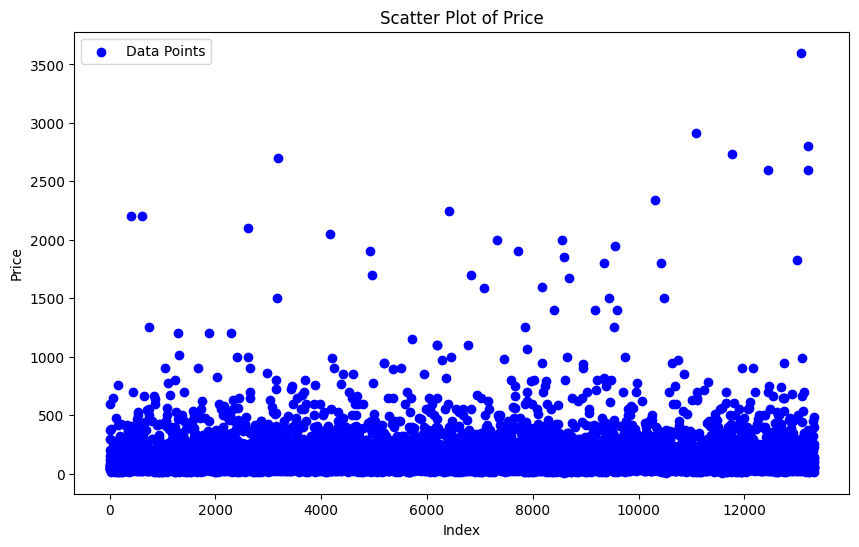

In [14]:
plt.figure(figsize=(10, 6))
plt.scatter(df.index, df['price'], color='blue', label='Data Points')
plt.title('Scatter Plot of Price')
plt.xlabel('Index')
plt.ylabel('Price')
plt.legend()
plt.show()

In [15]:
def outlier_(col):
    q1 = col.quantile(0.25)
    q3 = col.quantile(0.75)
    iqr = q3 - q1

    upper_limit = q3 + 1.5 * iqr
    lower_limit = q1 - 1.5 * iqr

    col = col.apply(lambda x: upper_limit if x > upper_limit else (lower_limit if x < lower_limit else x))
    
    return col

In [16]:
df['price'] = outlier_(df['price'])

<AxesSubplot:xlabel='price'>

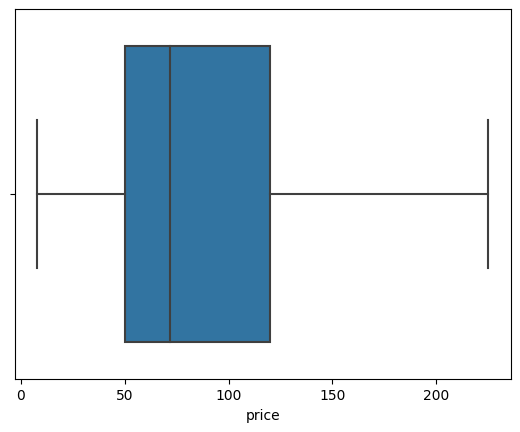

In [17]:
sns.boxplot(x=df['price'])

In [18]:
obj_cols = []
num_cols = []
for col in df.columns:
    if df[col].dtype == 'object':
        obj_cols.append(col)
    else:
        num_cols.append(col)
num_cols.remove('price')

In [19]:
print(obj_cols)
print(num_cols)

['area_type', 'availability', 'location', 'society']
['size', 'total_sqft', 'bath', 'balcony']


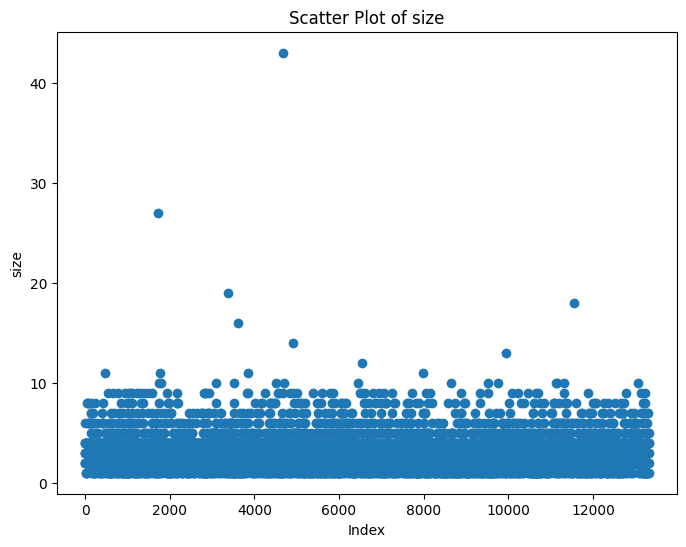

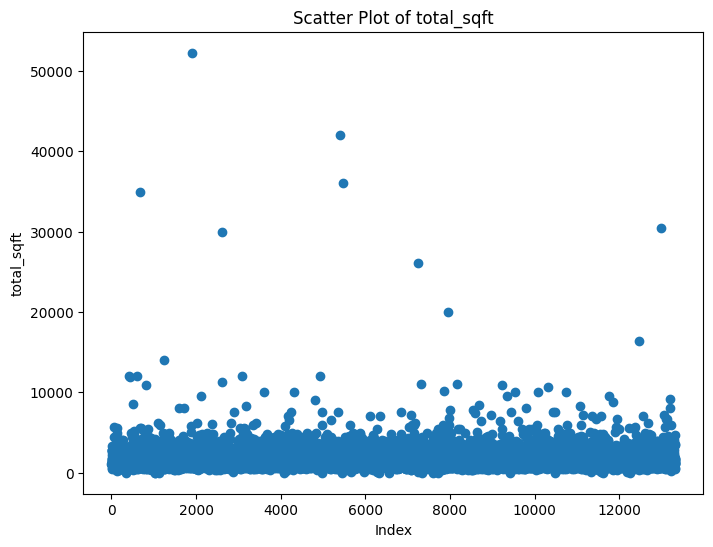

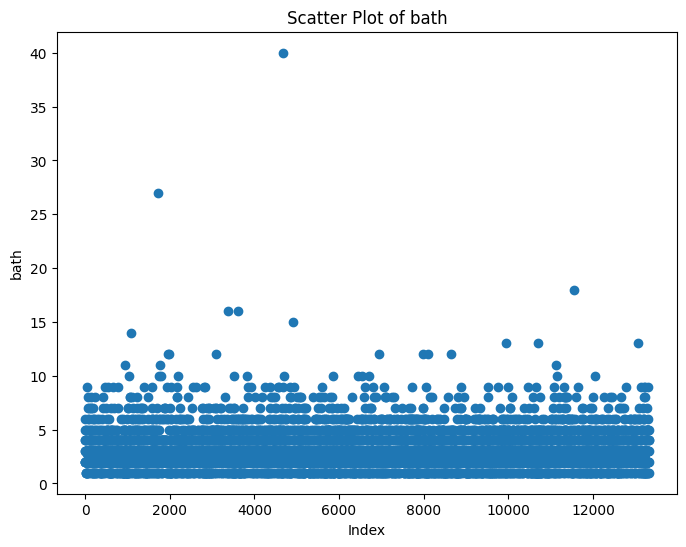

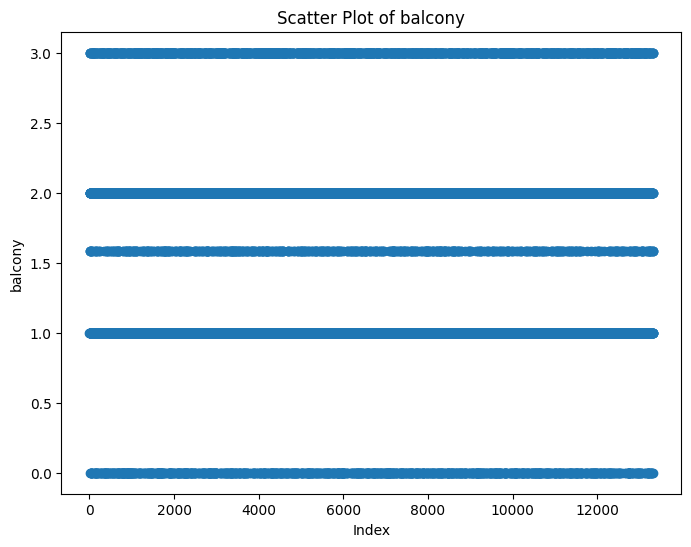

In [20]:
for col in num_cols:
    plt.figure(figsize=(8, 6))
    plt.scatter(range(len(df[col])), df[col]) 
    plt.xlabel('Index')
    plt.ylabel(col)
    plt.title(f'Scatter Plot of {col}')
    plt.show()

In [21]:
for col in num_cols:
    df[col] = outlier_(df[col])

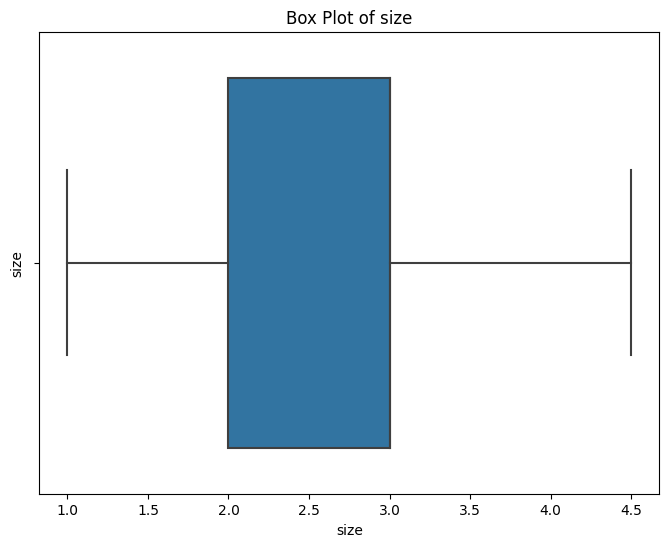

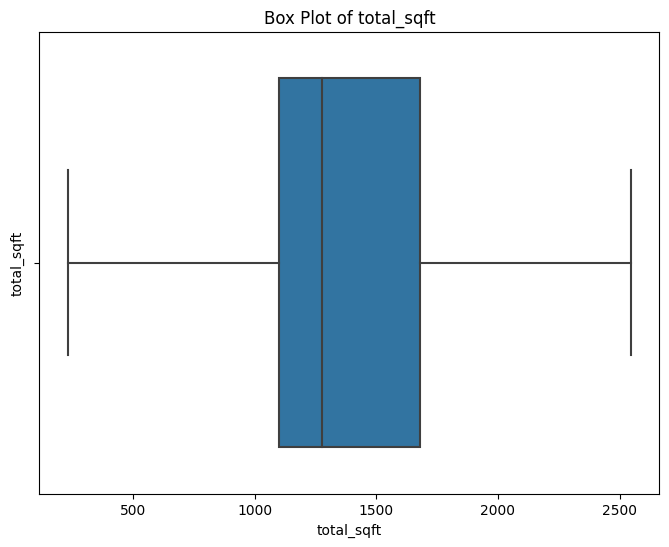

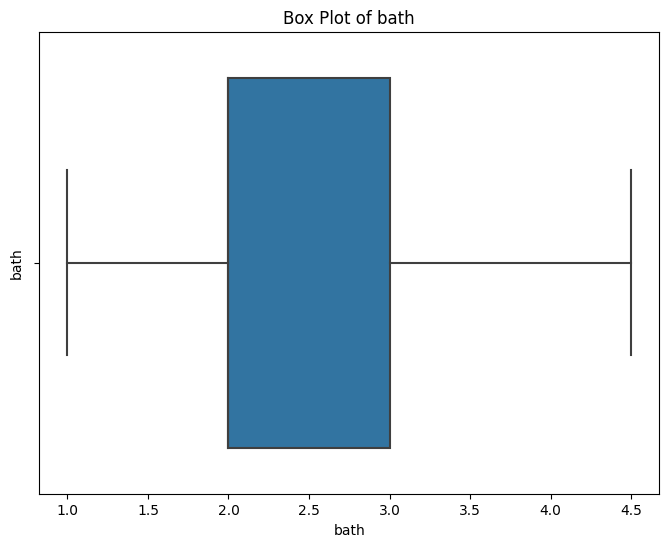

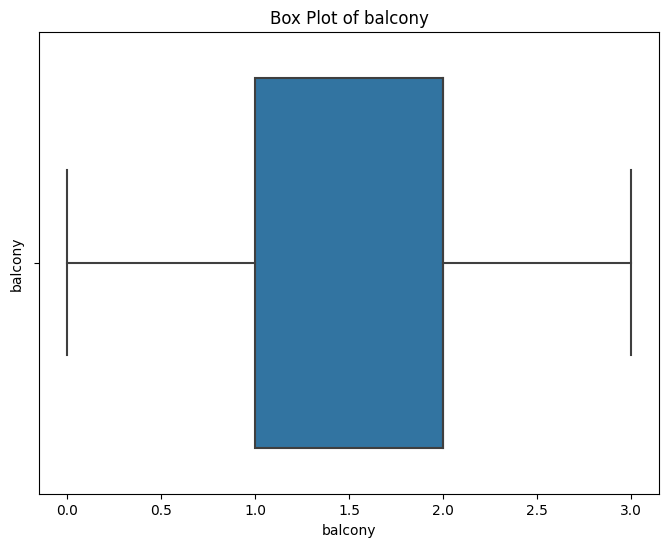

In [22]:
for col in num_cols:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=df[col])  
    plt.ylabel(col)
    plt.title(f'Box Plot of {col}')
    plt.show()

In [23]:
l = df['availability'].unique().tolist()
print(l)

['19-Dec', 'Ready To Move', '18-May', '18-Feb', '18-Nov', '20-Dec', '17-Oct', '21-Dec', '19-Sep', '20-Sep', '18-Mar', '20-Feb', '18-Apr', '20-Aug', '18-Oct', '19-Mar', '17-Sep', '18-Dec', '17-Aug', '19-Apr', '18-Jun', '22-Dec', '22-Jan', '18-Aug', '19-Jan', '17-Jul', '18-Jul', '21-Jun', '20-May', '19-Aug', '18-Sep', '17-May', '17-Jun', '21-May', '18-Jan', '20-Mar', '17-Dec', '16-Mar', '19-Jun', '22-Jun', '19-Jul', '21-Feb', 'Immediate Possession', '19-May', '17-Nov', '20-Oct', '20-Jun', '19-Feb', '21-Oct', '21-Jan', '17-Mar', '17-Apr', '22-May', '19-Oct', '21-Jul', '21-Nov', '21-Mar', '16-Dec', '22-Mar', '20-Jan', '21-Sep', '21-Aug', '14-Nov', '19-Nov', '15-Nov', '16-Jul', '15-Jun', '17-Feb', '20-Nov', '20-Jul', '16-Sep', '15-Oct', '15-Dec', '16-Oct', '22-Nov', '15-Aug', '17-Jan', '16-Nov', '20-Apr', '16-Jan', '14-Jul']


In [24]:
def convert_to_days_remaining(date_str):
    if date_str == 'Ready To Move' or date_str == 'Immediate Possession':
        return 0
    else:
        current_year = datetime.now().year
        formatted_date_str = f"{date_str}-{current_year}"
        date_object = datetime.strptime(formatted_date_str, '%d-%b-%Y')
        if date_object < datetime.now():
            formatted_date_str = f"{date_str}-{current_year + 1}"
            date_object = datetime.strptime(formatted_date_str, '%d-%b-%Y')
        delta = date_object - datetime.now()
        return abs(delta.days)

In [25]:
df['availability'] = df['availability'].apply(convert_to_days_remaining)

In [26]:
obj_cols.remove('availability')
num_cols.append('availability')

In [27]:
df.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,53,Electronic City Phase II,2.0,Coomee,1056.000,2.0,1.0,39.07
1,Plot Area,0,Chikka Tirupathi,4.0,Theanmp,2548.125,4.5,3.0,120.00
2,Built-up Area,0,Uttarahalli,3.0,GrrvaGr,1440.000,2.0,3.0,62.00
3,Super built-up Area,0,Lingadheeranahalli,3.0,Soiewre,1521.000,3.0,1.0,95.00
4,Super built-up Area,0,Kothanur,2.0,GrrvaGr,1200.000,2.0,1.0,51.00


## visualizations

In [28]:
def plot_continuous_distribution(data: pd.DataFrame = None, column: str = None, height: int = 8):
  _ = sns.displot(data, x=column, kde=True, height=height, aspect=height/5).set(title=f'Distribution of {column}');

def get_unique_values(data, column):
  num_unique_values = len(data[column].unique())
  value_counts = data[column].value_counts()
  print(f"Column: {column} has {num_unique_values} unique values\n")
  print(value_counts)
    
def plot_categorical_distribution(data: pd.DataFrame = None, column: str = None, height: int = 8, aspect: int = 2, top_categories: int = 5):
    top_categories_data = data[column].value_counts().nlargest(top_categories)
    plt.figure(figsize=(height, height/aspect))
    sns.countplot(data=data[data[column].isin(top_categories_data.index)], x=column, order=top_categories_data.index)
    plt.title(f'Top Categories in {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.show()

In [29]:
for col in obj_cols:
    get_unique_values(df, col)

Column: area_type has 4 unique values

Super built-up  Area    8790
Built-up  Area          2418
Plot  Area              2025
Carpet  Area              87
Name: area_type, dtype: int64
Column: location has 1305 unique values

Whitefield                        541
Sarjapur  Road                    399
Electronic City                   302
Kanakpura Road                    273
Thanisandra                       234
                                 ... 
Bapuji Layout                       1
1st Stage Radha Krishna Layout      1
BEML Layout 5th stage               1
singapura paradise                  1
Abshot Layout                       1
Name: location, Length: 1305, dtype: int64
Column: society has 2688 unique values

GrrvaGr    5582
PrarePa      76
Sryalan      59
Prtates      59
GMown E      56
           ... 
Amionce       1
JaghtDe       1
Jauraht       1
Brity U       1
RSntsAp       1
Name: society, Length: 2688, dtype: int64


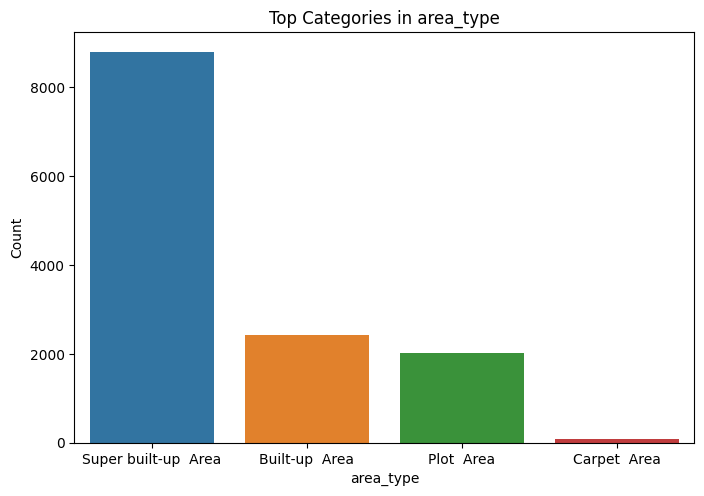

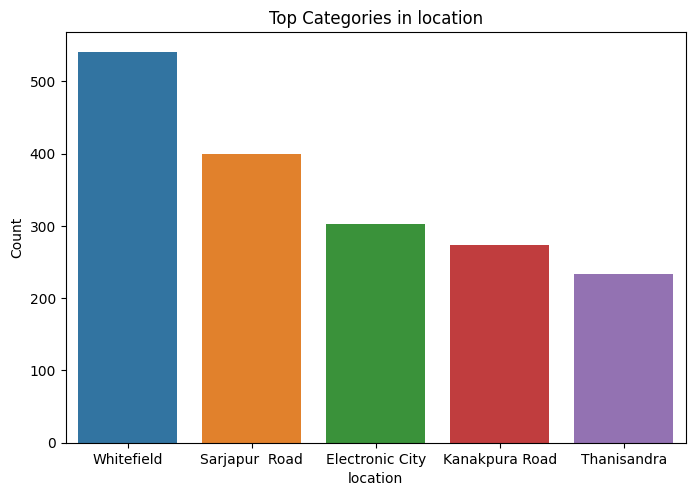

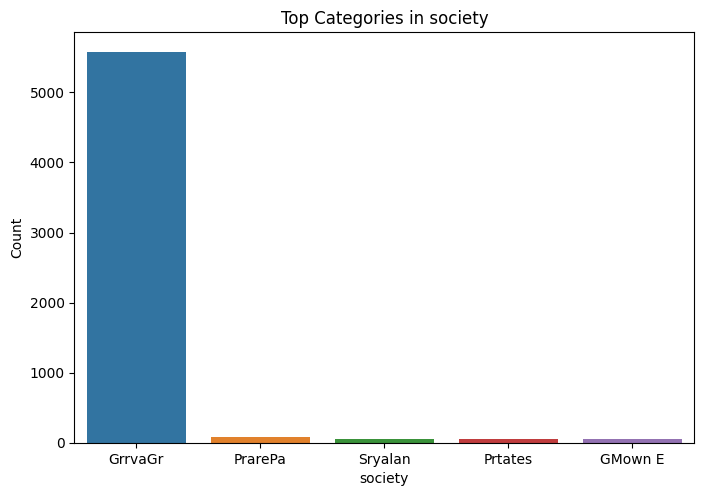

In [30]:
for col in obj_cols:
    plot_categorical_distribution(df, col, height = 8, aspect = 1.5)

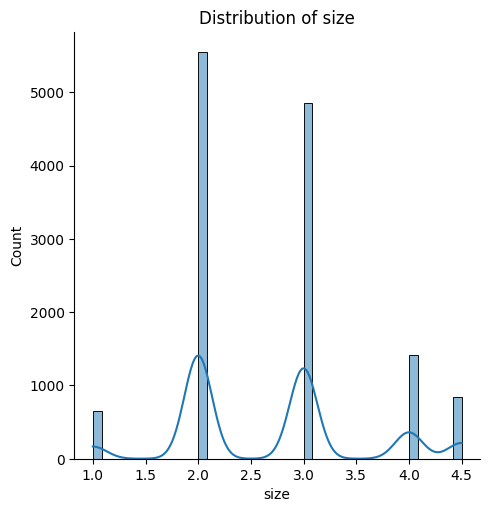

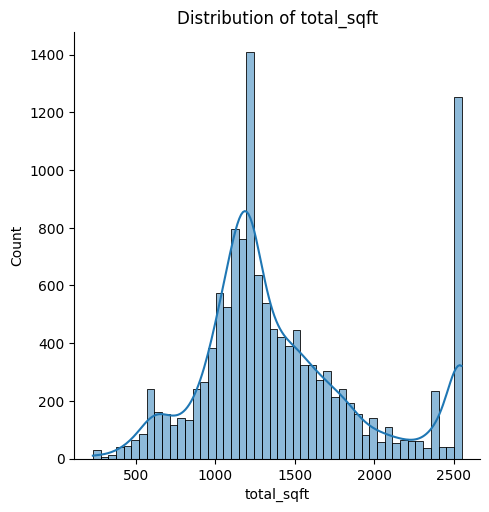

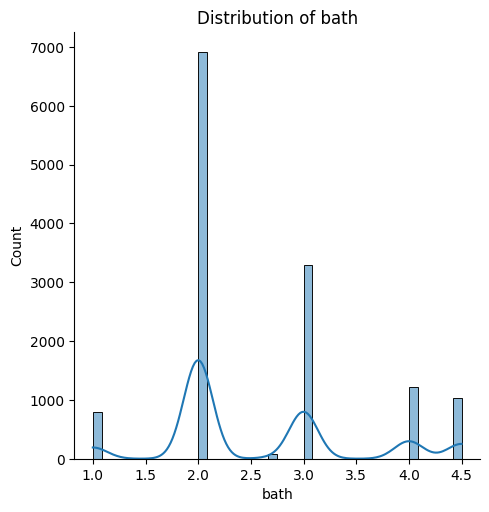

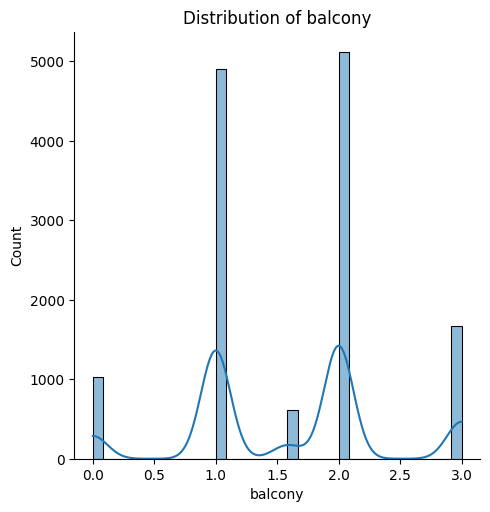

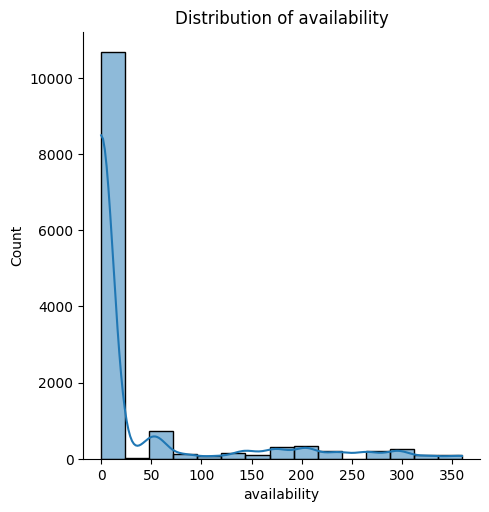

In [31]:
for col in num_cols:
    plot_continuous_distribution(df, col, height = 5)

In [32]:
def continuous_vs_target(df, continuous_variable, target_variable):
    plt.figure(figsize=(7, 5))
    sns.lineplot(x=continuous_variable, y=target_variable, data=df, marker='o', color='b')
    plt.title(f'{continuous_variable} vs {target_variable}', fontsize=14)
    plt.xlabel(continuous_variable, fontsize=12)
    plt.ylabel(target_variable, fontsize=12)
    plt.grid(True)
    plt.show()

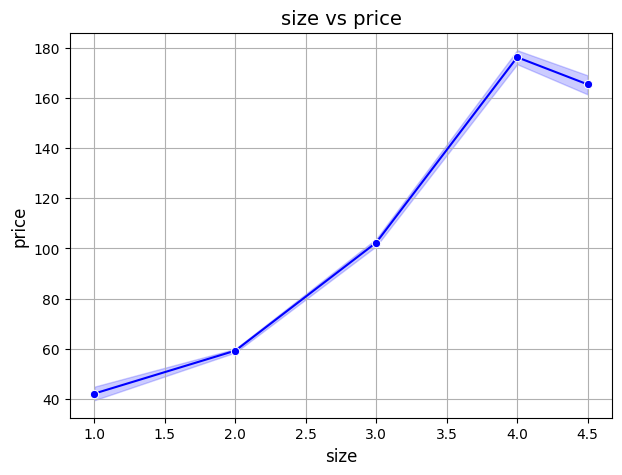

In [33]:
continuous_vs_target(df, 'size', 'price')

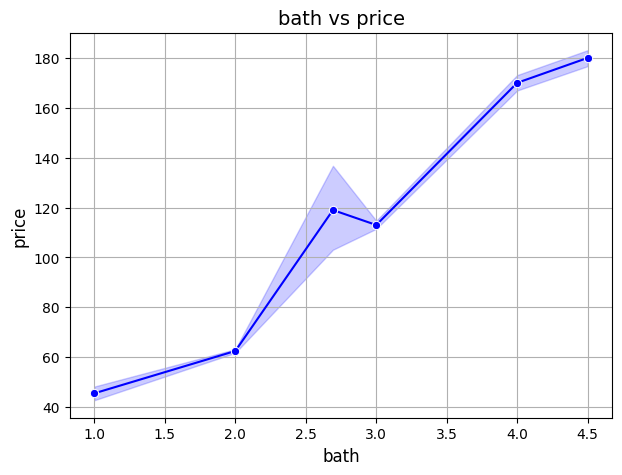

In [34]:
continuous_vs_target(df, 'bath', 'price')

In [35]:
def categorical_vs_target(df, cat_var, target_var):
    plt.figure(figsize=(7, 5))
    sns.lineplot(x=cat_var, y=target_var, data=df, marker='o', ci=None)
    plt.title(f'{cat_var} vs {target_var}')
    plt.xlabel(cat_var)
    plt.ylabel(target_var)
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

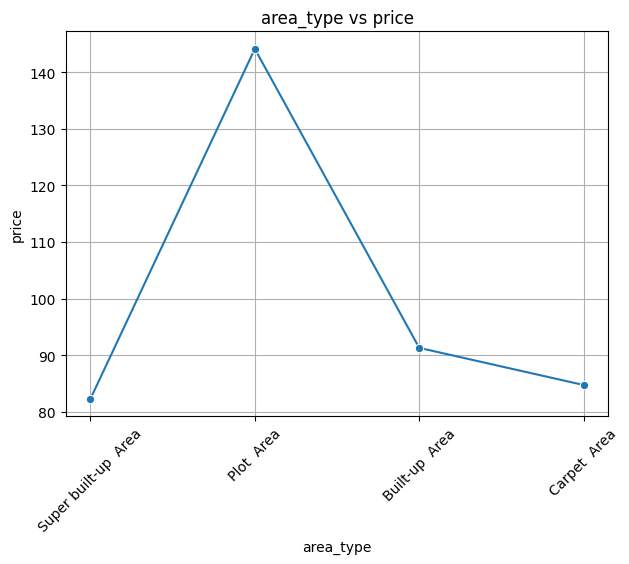

In [36]:
categorical_vs_target(df, 'area_type', 'price')

In [37]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,availability,size,total_sqft,bath,balcony,price
availability,1.000000,-0.081984,-0.029880,-0.065052,-0.081532,-0.079694
size,-0.081984,1.000000,0.624403,0.869467,0.236492,0.668034
total_sqft,-0.029880,0.624403,1.000000,0.651482,0.250353,0.749889
bath,-0.065052,0.869467,0.651482,1.000000,0.248958,0.709635
balcony,-0.081532,0.236492,0.250353,0.248958,1.000000,0.163739
price,-0.079694,0.668034,0.749889,0.709635,0.163739,1.000000


## Insights from data
1. Size of houses is between 1 to 4.5 BHK
2. Maximum total square feet is 2500 sqft
3. size, total_sqft and bath affetcts the prices of the house
4. Top 5 categories in location are Whitefield, Sarjapur  Road, Electronic City, Kanakpura Road, Thanisandra   

## encoding categorical variables

In [38]:
one_hot_encoded = pd.get_dummies(df['area_type'], prefix=col)    
df = pd.concat([df, one_hot_encoded], axis=1)
df.drop('area_type', axis=1, inplace=True)

In [39]:
df.head()

,availability,location,size,society,total_sqft,bath,balcony,price,availability_Built-up Area,availability_Carpet Area,availability_Plot Area,availability_Super built-up Area
0,53,Electronic City Phase II,2.0,Coomee,1056.000,2.0,1.0,39.07,0,0,0,1
1,0,Chikka Tirupathi,4.0,Theanmp,2548.125,4.5,3.0,120.00,0,0,1,0
2,0,Uttarahalli,3.0,GrrvaGr,1440.000,2.0,3.0,62.00,1,0,0,0
3,0,Lingadheeranahalli,3.0,Soiewre,1521.000,3.0,1.0,95.00,0,0,0,1
4,0,Kothanur,2.0,GrrvaGr,1200.000,2.0,1.0,51.00,0,0,0,1


In [40]:
encoder = ce.BinaryEncoder(cols=['society', 'location'])
df = encoder.fit_transform(df)

print(df.shape)

(13320, 33)


## splitting data

In [41]:
X = df.drop(['price'], axis=1)
y = df['price']

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

In [43]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(10656, 32) (10656,)
(2664, 32) (2664,)


In [44]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [45]:
model_RFR = RandomForestRegressor(n_estimators=10)
model_RFR.fit(X_train_scaled, y_train)
y_pred = model_RFR.predict(X_test_scaled)

print("R-squared", r2_score(y_test, y_pred))

R-squared 0.7379741985860324


In [46]:
model_xgb = XGBRegressor()
model_xgb.fit(X_train_scaled, y_train)
y_pred = model_xgb.predict(X_test_scaled)

print("R-squared", r2_score(y_test, y_pred))

R-squared 0.7601075584588395


In [47]:
model_LR = LinearRegression()
model_LR.fit(X_train_scaled, y_train)
y_pred = model_LR.predict(X_test_scaled)

print("R-squared", r2_score(y_test, y_pred))

R-squared 0.6757060764360541


#### Top 10 Feature Importances

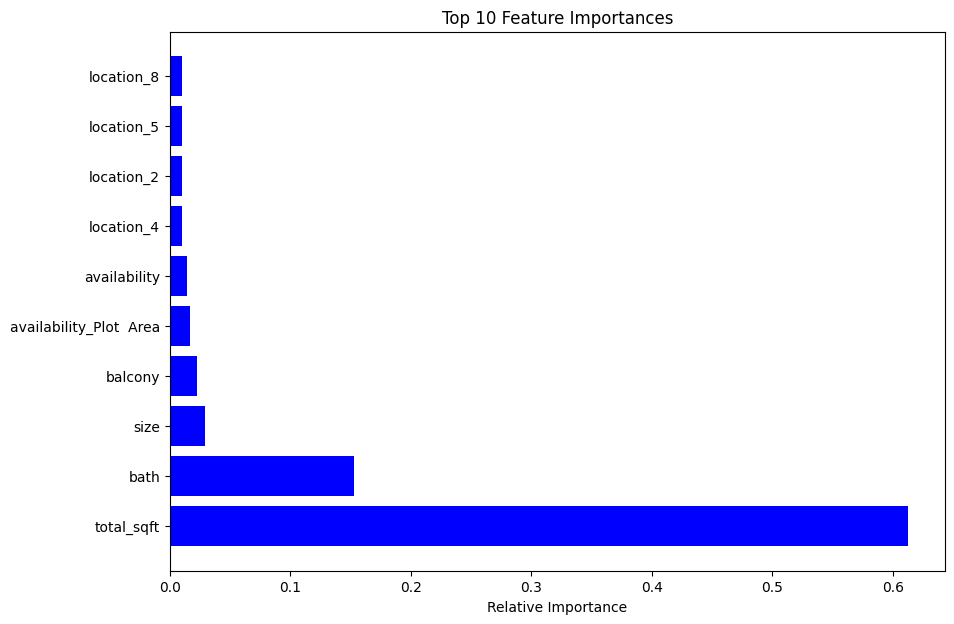

In [48]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

top_features = list(X.columns[indices[:10]])
top_importances = importances[indices[:10]]

fig, ax = plt.subplots(figsize=(10, 7))
plt.title('Top 10 Feature Importances')
plt.barh(range(len(top_features)), top_importances, color='b', align='center')
plt.yticks(range(len(top_features)), top_features)
plt.xlabel('Relative Importance')
plt.show()